# Concepts attribution for fCRP-EfficientNet

In [1]:
!nvidia-smi

Thu May 22 14:22:46 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:81:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      4MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [84]:
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from utils import read_json

import math
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial import distance

In [4]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

from crp.image import imgify

In [5]:
json = read_json('config_prostate.json')
model_chkpt = 'checkpoints/JacobEfficientNet/model_best.pth'

In [6]:
config = ConfigParser(json, resume=model_chkpt)

In [7]:
checkpoint = torch.load(config.resume, weights_only = False)
state_dict = checkpoint['state_dict']

In [8]:
model = config.init_obj('arch', module_arch)

model.load_state_dict(state_dict)
model.eval()

data_loader = config.init_obj('data_loader_test', module_data)
sample_subset = [data_loader.dataset[i] for i in {600, 700, 800, 1000, 1100, 20}]

/mnt/homeGPU/sjhu/conda_env/crp/lib/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
sample_subset[0][0].shape

torch.Size([3, 374, 374])

In [10]:
sample, idx = sample_subset[0]

In [11]:
model(sample.unsqueeze(0)).argmax()

tensor(3)

In [23]:
def generate_results():
	model.eval()
	for (input, label) in sample_subset:
		output = model(input.unsqueeze(0))
		pred_class = output.argmax()
		print(f"Model prediction {pred_class}. GT-Label: {label}")
	model.train()

generate_results()

Model prediction 3. GT-Label: 3
Model prediction 6. GT-Label: 6
Model prediction 10. GT-Label: 10
Model prediction 0. GT-Label: 0
Model prediction 3. GT-Label: 3
Model prediction 3. GT-Label: 3


In [13]:
from crp.helper import get_layer_names

conditions = [{"y": 46}]
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

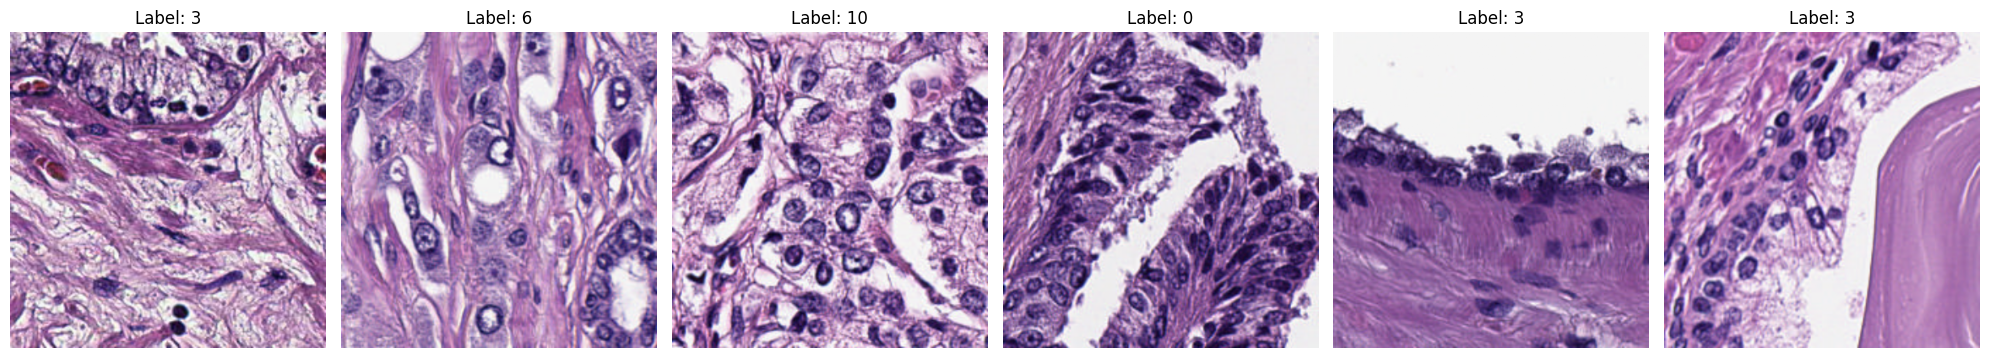

In [14]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.
    Args:
        tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list or tuple): Mean values for each channel.
        std (list or tuple): Standard deviation values for each channel.
    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean).view(tensor.shape[0], 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std).view(tensor.shape[0], 1, 1)

    return tensor * std + mean

def visualize_batch_denormalized(list_tensors, mean, std, titles=None, num_cols=4, figsize=None):
    """
    Visualizes a batch of DENORMALIZED image tensors in a grid.
    Args:
        list_tensors (torch.Tensor): List of image tensors (C, H, W), ASSUMED NORMALIZED.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.
        titles (list of str, optional): List of titles for each image.
        num_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size (width, height).
    """
    batch_size = len(list_tensors)
    num_rows = math.ceil(batch_size / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(list_tensors):
        ax = axes[i]
        
        # Denormalize the image tensor
        denormalized_img_tensor = denormalize(img_tensor, mean, std)

        # Convert to numpy and handle channel order
        if denormalized_img_tensor.shape[0] == 1: # Grayscale
            img_np = denormalized_img_tensor.squeeze().cpu().numpy()
        else: # RGB
            img_np = denormalized_img_tensor.permute(1, 2, 0).cpu().numpy()
            
        # Clip values to [0, 1] in case of floating point inaccuracies
        img_np = np.clip(img_np, 0, 1)
            
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title("sample")
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Label: {label}")
        
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_denormalized(sample_subset, data_loader.dataset.normalize_mean, data_loader.dataset.normalize_std, num_cols=6, figsize=(20, 7))

In [29]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

cc = ChannelConcept()

attr = attribution(input_zennit, conditions, composite, record_layer=layer_names)
rel_c = cc.attribute(attr.relevances['model.features.8.0'], abs_norm=True)

In [36]:
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([ 897,  520,    1, 1260,  275,  529,  454,  728,  383,  365,   22, 1056,
          669,  938,  363,  259, 1048,  654,   84,  462]),
 tensor([2.0649, 1.6823, 1.1731, 1.0296, 0.8665, 0.8524, 0.8046, 0.7314, 0.6864,
         0.6864, 0.6752, 0.6076, 0.5851, 0.5739, 0.5598, 0.4726, 0.4670, 0.4445,
         0.4276, 0.4206]))

In [102]:
conditions = [{'model.features.8.0': [id], 'y': [3]} for id in concept_ids]
heatmap, _, _, _ = attribution(input_zennit, conditions, composite)

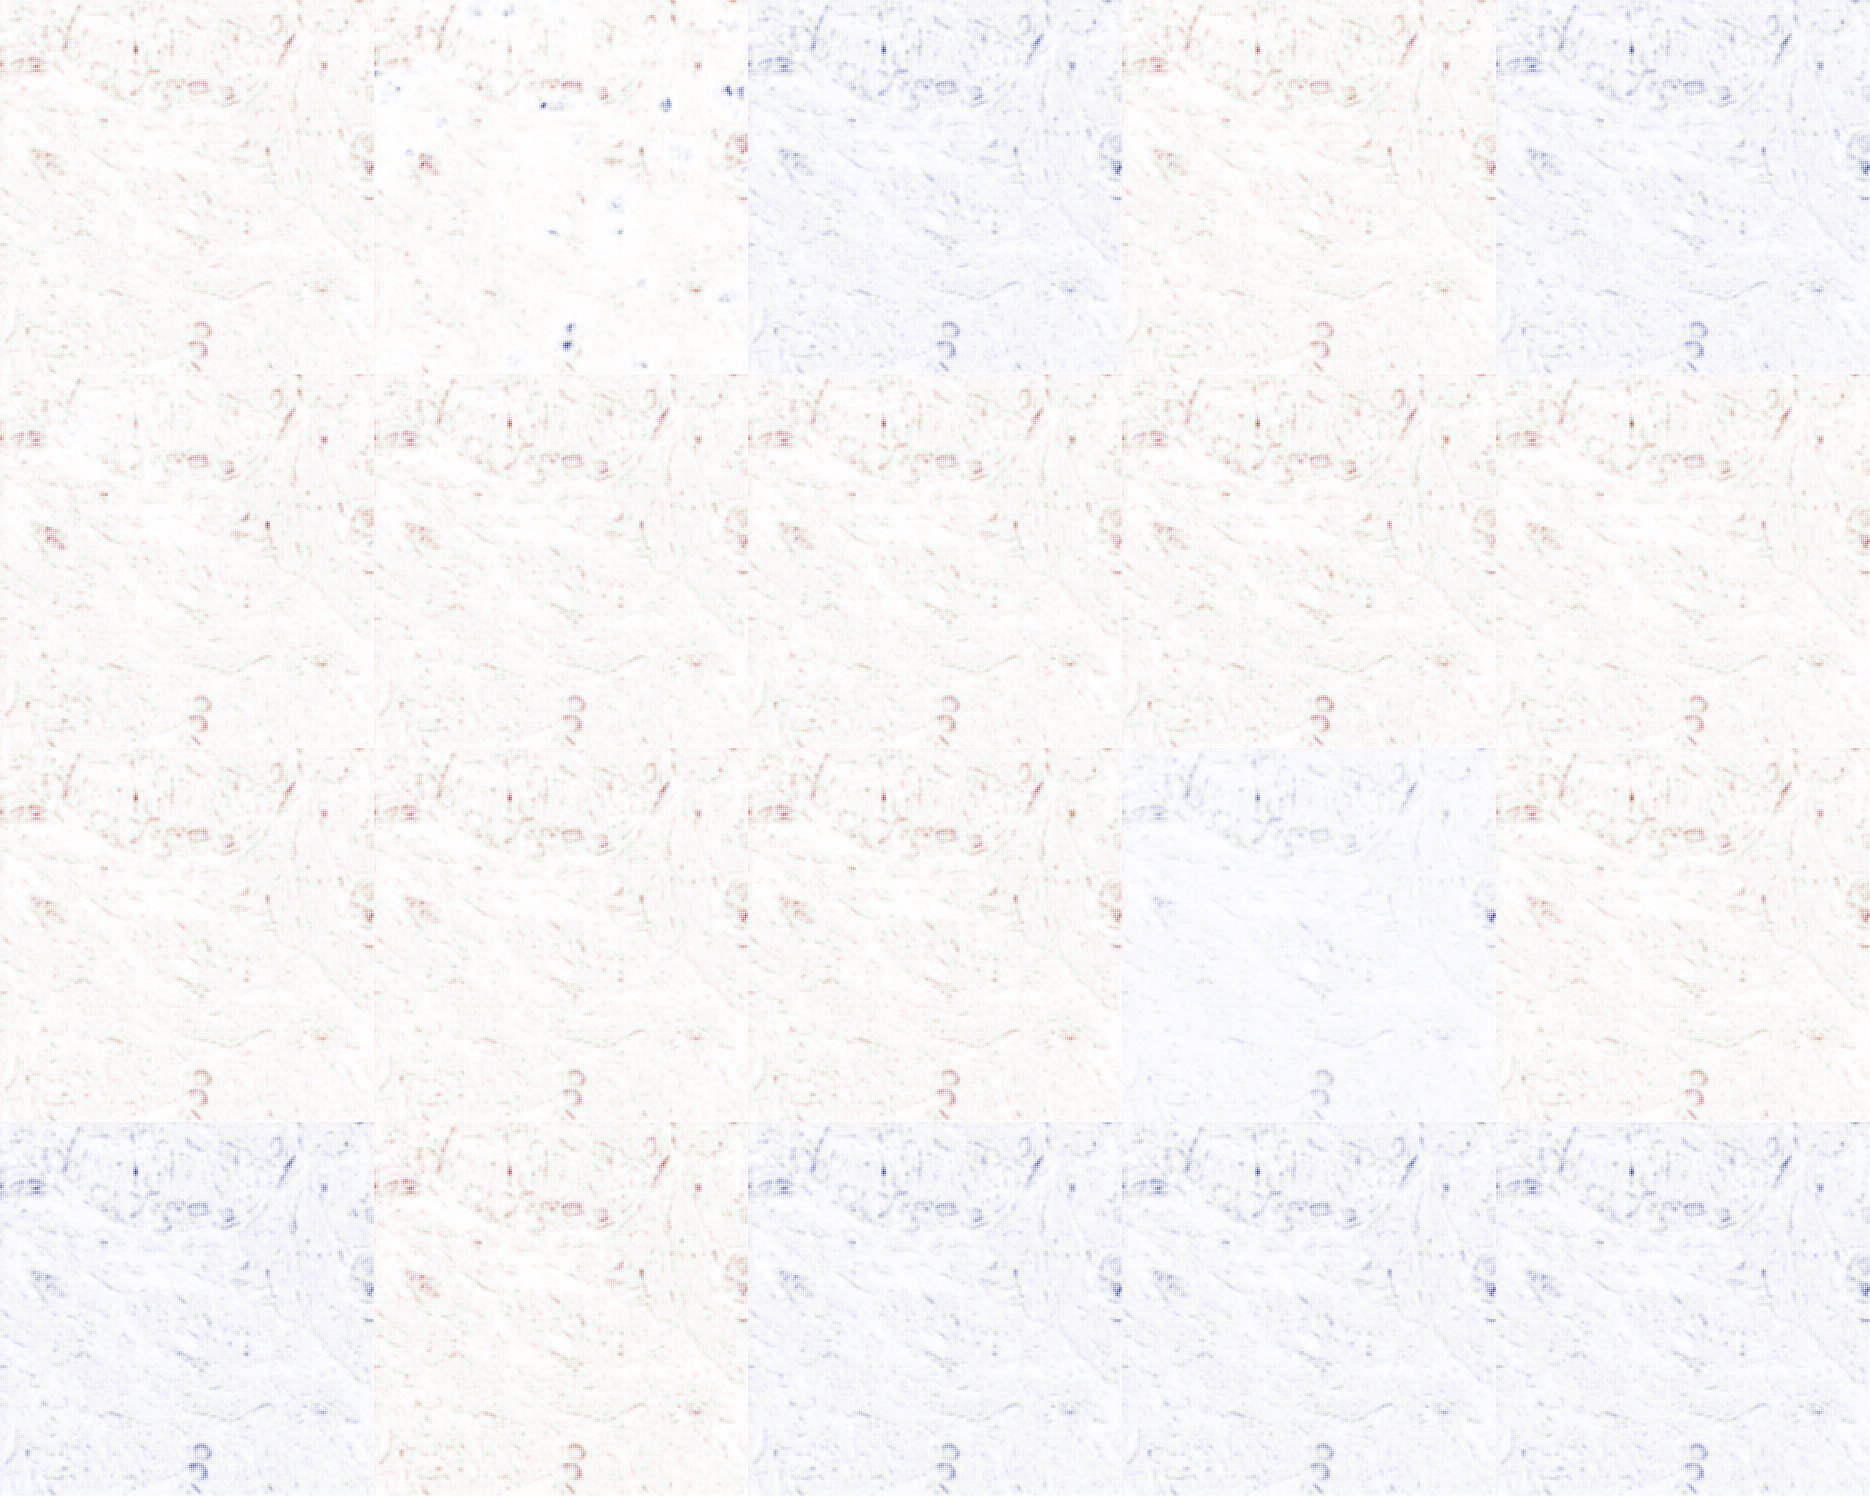

In [104]:
imgify(heatmap, symmetric=True, grid=(4,5))

In [47]:
heatmap[0] - heatmap[1]

tensor([[-0.4743, -0.5974, -0.1231,  ..., -1.6075, -1.0991, -1.0991],
        [-0.6852, -0.9163, -0.2311,  ..., -2.3373, -1.6404, -1.6404],
        [-0.2108, -0.3188, -0.1080,  ..., -0.7297, -0.5413, -0.5413],
        ...,
        [-0.5419, -0.6574, -0.1155,  ..., -0.4851, -0.2595, -0.2595],
        [-0.2557, -0.3185, -0.0628,  ..., -0.2956, -0.1492, -0.1492],
        [-0.2557, -0.3185, -0.0628,  ..., -0.2956, -0.1492, -0.1492]])

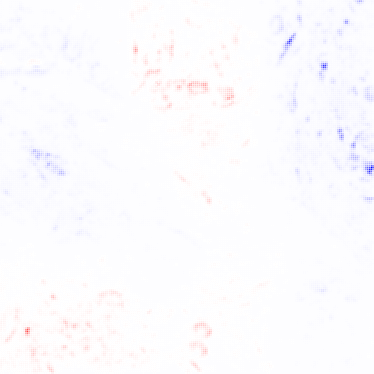

In [108]:
conditions = [{'model.features.8.0': [20], 'y': [3]}]
heatmap_rand, _, _, _ = attribution(input_zennit, conditions, composite)
imgify(heatmap_rand, symmetric=True)

In [111]:
scipy.stats.pearsonr(heatmap[0].flatten(), heatmap_rand.flatten())[0]

np.float32(-0.09351853)

In [122]:
def find_ess_heatmaps(heatmaps, tol=0.1):
	unique = []
	neg_tol = 1 - tol

	for hm in heatmaps:
		found = False
		for elem in unique:
			pearson = scipy.stats.pearsonr(elem.flatten(), hm.flatten())[0]

			if np.abs(pearson) > neg_tol:
				found = True
				break

		if not found:
			unique.append(hm)

	final_heatmap = torch.stack(unique)
	return final_heatmap

unique_heatmap = find_ess_heatmaps(heatmap)

In [125]:
unique_heatmap.shape

torch.Size([2, 374, 374])

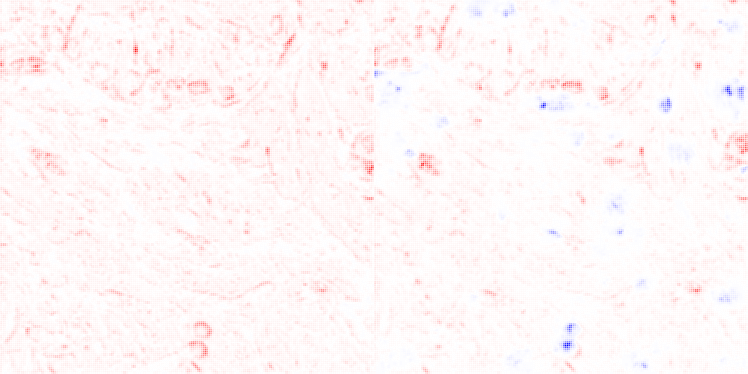

In [123]:
imgify(unique_heatmap, symmetric=True, grid=(1,2))

In [130]:
input_zennit.shape

torch.Size([1, 3, 374, 374])

In [114]:
torch.stack([
	torch.Tensor([1,2,3]),
torch.Tensor([1,2,3]),
])

tensor([[1., 2., 3.],
        [1., 2., 3.]])